# Loan Approval prediction using Artificial Neaural Network
In this notebook , we will train the deep neural network model , extract the hdf5 weight file and will try to deploy that keras model+weight file in another py file and do mobile deployment of the deep neural network.

In [38]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Accuracy
import matplotlib.pyplot as plt

In [39]:
bank_df = pd.read_csv("/kaggle/input/unibankdataset/UniversalBank.csv")

In [40]:
bank_df.head()

,ID,Age,Experience,Income,ZIP Code,Family,CCAvg,Education,Mortgage,Personal Loan,Securities Account,CD Account,Online,CreditCard
0,1,25,1,49,91107,4,1.6,1,0,0,1,0,0,0
1,2,45,19,34,90089,3,1.5,1,0,0,1,0,0,0
2,3,39,15,11,94720,1,1.0,1,0,0,0,0,0,0
3,4,35,9,100,94112,1,2.7,2,0,0,0,0,0,0
4,5,35,8,45,91330,4,1.0,2,0,0,0,0,0,1


In [41]:
bank_df.shape

(5000, 14)

## Attributes
- ID: Customer ID
- Age: Customer Age
- Experience: Amount of work experience in years
- Income: Amount of annual income (in thousands)
- Zipcode: Zipcode of where customer lives
- Family: Number of family members
- CCAvg: Average monthly credit card spendings
- Education: Education level (1: Bachelor, 2: Master, 3: Advanced Degree)
- Mortgage: Mortgage of house (in thousands)
- Securities Account: Boolean of whether customer has a securities account
- CD Account: Boolean of whether customer has Certificate of Deposit account
- Online: Boolean of whether customer uses online banking
- CreditCard: Does the customer use credit card issued by the bank?
- Personal Loan: This is the target variable (Binary Classification Problem)

In [42]:
bank_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  5000 non-null   int64  
 1   Age                 5000 non-null   int64  
 2   Experience          5000 non-null   int64  
 3   Income              5000 non-null   int64  
 4   ZIP Code            5000 non-null   int64  
 5   Family              5000 non-null   int64  
 6   CCAvg               5000 non-null   float64
 7   Education           5000 non-null   int64  
 8   Mortgage            5000 non-null   int64  
 9   Personal Loan       5000 non-null   int64  
 10  Securities Account  5000 non-null   int64  
 11  CD Account          5000 non-null   int64  
 12  Online              5000 non-null   int64  
 13  CreditCard          5000 non-null   int64  
dtypes: float64(1), int64(13)
memory usage: 547.0 KB


## Preparing the data for training

In [57]:
from tensorflow.keras.utils import to_categorical

X = bank_df.drop(columns=["Personal Loan"])
y = bank_df["Personal Loan"]

y = to_categorical(y)

In [58]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((4500, 13), (500, 13), (4500, 2), (500, 2))

## Building a multi-layer neural network model
Now we will build a multi-layer neural network model with the help of tensorflow Keras module

In [59]:
# sequential model
ann_model = keras.Sequential()

# adding dense layer
ann_model.add(Dense(250, input_dim=13, kernel_initializer='normal', activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(500, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(500, activation='relu'))
ann_model.add(Dropout(0.3))
ann_model.add(Dense(500, activation='relu'))
ann_model.add(Dropout(0.4))
ann_model.add(Dense(250, activation='linear'))
ann_model.add(Dropout(0.4))

# adding dense layer with softmax activation/output layer
ann_model.add(Dense(2, activation='softmax'))
ann_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 250)               3500      
                                                                 
 dropout_5 (Dropout)         (None, 250)               0         
                                                                 
 dense_7 (Dense)             (None, 500)               125500    
                                                                 
 dropout_6 (Dropout)         (None, 500)               0         
                                                                 
 dense_8 (Dense)             (None, 500)               250500    
                                                                 
 dropout_7 (Dropout)         (None, 500)               0         
                                                                 
 dense_9 (Dense)             (None, 500)              

## Compiling and training the Keras model

In [60]:
# custom functions for f1, precision and recall

from keras import backend as K

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [61]:
ann_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=[f1_m]) # metrics=['accuracy']

In [62]:
history = ann_model.fit(X_train, y_train, epochs=25, validation_split=0.23, verbose=1)

Epoch 1/25
109/109 [==============================] - 3s 7ms/step - loss: 0.1927 - f1_m: 0.9289 - val_loss: 0.1160 - val_f1_m: 0.9545
Epoch 2/25
109/109 [==============================] - 0s 4ms/step - loss: 0.0971 - f1_m: 0.9659 - val_loss: 0.1230 - val_f1_m: 0.9574
Epoch 3/25
109/109 [==============================] - 0s 4ms/step - loss: 0.0851 - f1_m: 0.9696 - val_loss: 0.0894 - val_f1_m: 0.9744
Epoch 4/25
109/109 [==============================] - 0s 4ms/step - loss: 0.0748 - f1_m: 0.9751 - val_loss: 0.0896 - val_f1_m: 0.9697
Epoch 5/25
109/109 [==============================] - 1s 7ms/step - loss: 0.0759 - f1_m: 0.9709 - val_loss: 0.0909 - val_f1_m: 0.9744
Epoch 6/25
109/109 [==============================] - 0s 5ms/step - loss: 0.0627 - f1_m: 0.9805 - val_loss: 0.0740 - val_f1_m: 0.9744
Epoch 7/25
109/109 [==============================] - 1s 5ms/step - loss: 0.0564 - f1_m: 0.9794 - val_loss: 0.0750 - val_f1_m: 0.9792
Epoch 8/25
109/109 [==============================] - 0s 4ms/s

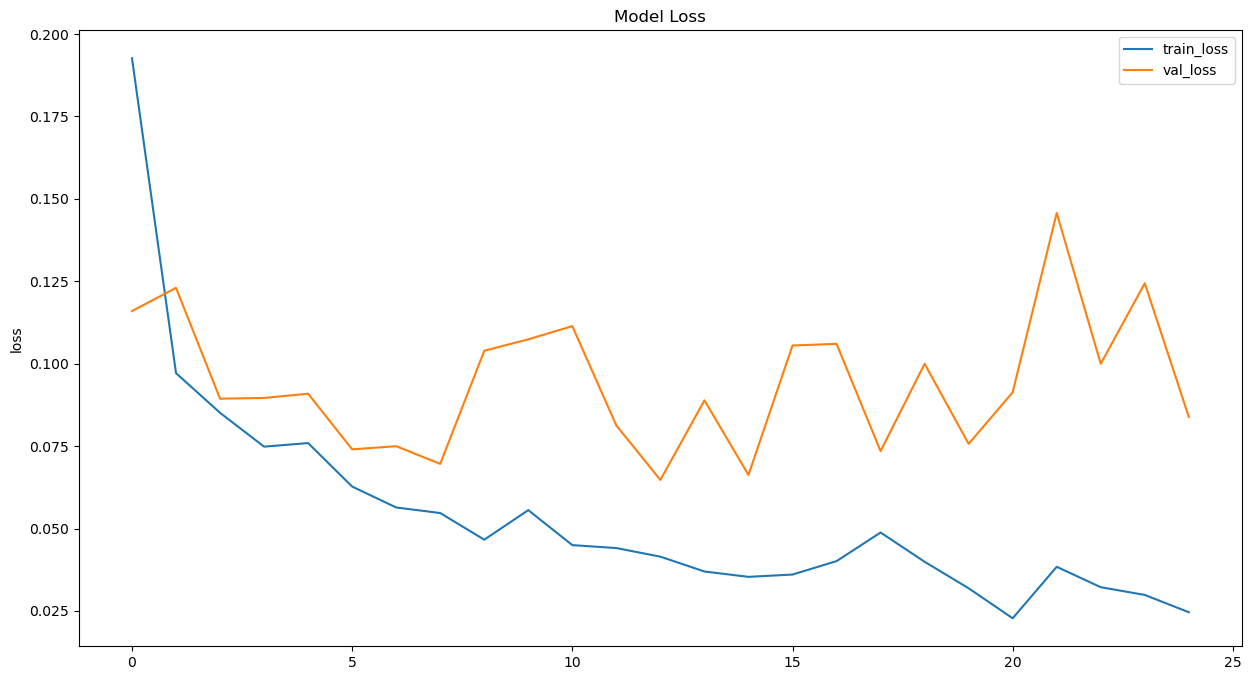

In [63]:
# Plot the model performance across epochs
plt.figure(figsize=(15,8))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.legend(['train_loss','val_loss'], loc = 'upper right')
plt.savefig('modelloss.png', facecolor='w', bbox_inches='tight')
plt.show()

## Doing performence analysis
Now , we should check if the model parameters are good enough or not.

In [64]:
predictions = ann_model.predict(X_test)
predict = []

for i in predictions:
    predict.append(np.argmax(i))

16/16 [==============================] - 0s 2ms/step


In [65]:
from sklearn import metrics
y_test = np.argmax(y_test, axis=1)

f1_test = metrics.f1_score(y_test, predict)
prec = metrics.precision_score(y_test, predict)
rec = metrics.recall_score(y_test, predict)
acc = metrics.accuracy_score(y_test, predict)

print ("F1 Score: {:.4f}.".format(f1_test))
print ("Precision: {:.4f}.".format(prec))
print ("Recall: {:.4f}.".format(rec))
print ("Accuracy: {:.4f}.".format(acc)) # note this is not a good measure of performance for this project as dataset is unbalanced.

F1 Score: 0.8791.
Precision: 0.9091.
Recall: 0.8511.
Accuracy: 0.9780.


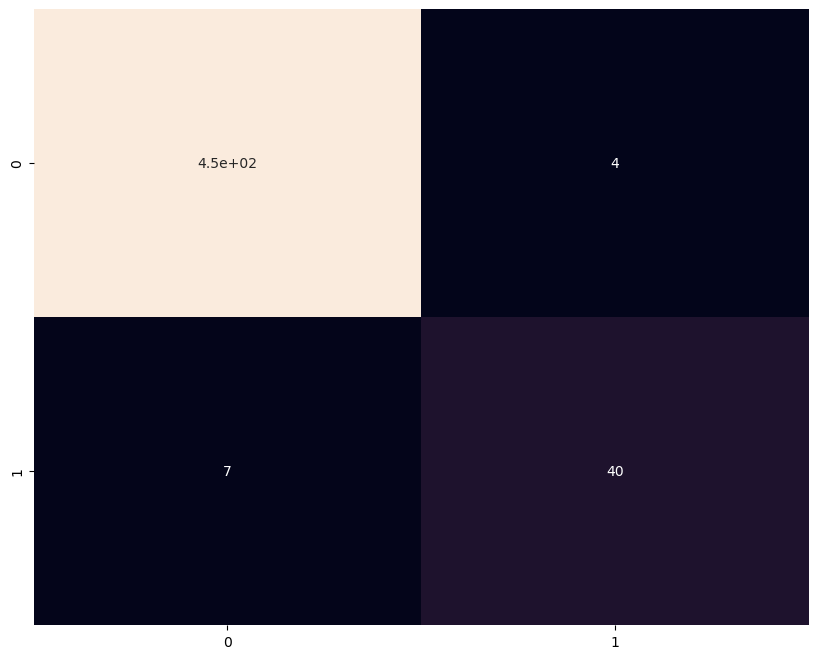

In [66]:
conf_mat = metrics.confusion_matrix(y_test, predict)
plt.figure(figsize=(10,8))
sns.heatmap(conf_mat, annot=True, cbar=False)
plt.savefig('conf_matrix.png', facecolor='w', bbox_inches='tight')
plt.show()

In [67]:
print(metrics.classification_report(y_test, predict))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99       453
           1       0.91      0.85      0.88        47

    accuracy                           0.98       500
   macro avg       0.95      0.92      0.93       500
weighted avg       0.98      0.98      0.98       500



## Exporting the model and the standard scaler object

In [ ]:
from tensorflow.keras.models import save_model
save_model(ann_model, 'new_model.h5')

In [ ]:
import pickle
from pathlib import Path
# Export StandardScaler object
with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)